# Evalaute Velocity and Direction Dependence
The goal of this notebook is to explore the velocity and direction dependence of stopping power, as predicted by the ML model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

Using TensorFlow backend.


## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [2]:
model = keras.models.load_model('model.h5')

In [3]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [5]:
channel_data = pd.read_pickle(os.path.join('data', 'channel_traj.pkl')).query('average_range')

## Make the Trajectory Integration Tool
This will black box the annoying parts of making the trajectories

In [6]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Evaluate Channel and Off Channel at Many Velocities
See how smoothly it varies and whether the difference between channel/not channel increases at higher velocities

In [7]:
channel_stopping = []
for gid, group in channel_data.groupby('directory'):
    channel_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
channel_stopping = pd.DataFrame(channel_stopping)

In [8]:
%%time
velocities = np.linspace(0.1, 8, 32)
stopping_power = [
    traj_int.compute_stopping_power([0, 0.75, 0.75], [1, 0, 0], v)[0]
    for v in velocities
]

CPU times: user 15.4 s, sys: 37.2 ms, total: 15.4 s
Wall time: 16.1 s


Run an off-channel trajecotory. I picked one that gives a pretty high stopping power

In [9]:
%%time
stopping_power_ooc = [
    traj_int.compute_stopping_power([0, 0.75, 0.75], [4, 2, 1], v)[0]
    for v in velocities
]

CPU times: user 6min 51s, sys: 1.13 s, total: 6min 52s
Wall time: 13min 27s


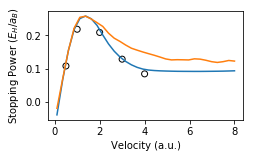

In [10]:
fig, ax = plt.subplots()

ax.plot(velocities, stopping_power, label='Channel')
ax.plot(velocities, stopping_power_ooc, label='Off Channel')

# Add in the points for the channel
ax.scatter(channel_stopping['velocity'], channel_stopping['stopping'], 
           facecolor='none', edgecolor='k')

ax.set_xlabel('Velocity (a.u.)')
ax.set_ylabel('Stopping Power ($E_H / a_B$)')

fig.set_size_inches(3.5, 2)
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.png'), dpi=320)

*Finding*: The stopping power doesn't go to (0, 0), and does seem like it will converge to 0. But, the model does capture that the low velocity regime is linear and the difference between the channel and off chanell gets bigger at higher velocities before merging again at very high velocities.